In [1]:
import os
from encodings.utf_16 import encode

import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# 1. 数据预处理
# 设置数据路径
pedestrian_dir = './data/pedestrians128x64_'  # 行人图片目录
non_pedestrian_dir = './data/pedestrians_neg'     # 负样本图片目录

# 获取行人图片路径
# pedestrian_paths = glob.glob(os.path.join(pedestrian_dir, '*.png'))
pedestrian_paths = glob.glob(os.path.join(pedestrian_dir, '*.ppm'))

# 获取负样本图片路径（假设目录中有多种格式）
non_pedestrian_paths = glob.glob(os.path.join(non_pedestrian_dir, '*.jpg'))
# non_pedestrian_paths += glob.glob(os.path.join(non_pedestrian_dir, '*.jpeg'))
# non_pedestrian_paths += glob.glob(os.path.join(non_pedestrian_dir, '*.png'))

# 确保样本数量平衡
min_samples = min(len(pedestrian_paths), len(non_pedestrian_paths))
pedestrian_paths = pedestrian_paths[:min_samples]
non_pedestrian_paths = non_pedestrian_paths[:min_samples]

print(f"正样本数量: {len(pedestrian_paths)}")
print(f"负样本数量: {len(non_pedestrian_paths)}")

def extract_hog_features(img_path):
    """提取图像的HOG特征"""
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None
        img = cv2.resize(img, (64, 128))  # 调整为标准大小
        fd = hog(img, orientations=9, pixels_per_cell=(8, 8),
                 cells_per_block=(2, 2), block_norm='L2-Hys')
        return fd
    except Exception as e:
        print(f"处理图像 {img_path} 时出错: {e}")
        return None

# 提取正样本特征
pedestrian_features = []
for path in pedestrian_paths:
    features = extract_hog_features(path)
    if features is not None:
        pedestrian_features.append(features)

# 提取负样本特征
non_pedestrian_features = []
for path in non_pedestrian_paths:
    features = extract_hog_features(path)
    if features is not None:
        non_pedestrian_features.append(features)

# 创建标签
X = np.vstack((pedestrian_features, non_pedestrian_features))
y = np.hstack((np.ones(len(pedestrian_features)), 
               np.zeros(len(non_pedestrian_features))))

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"训练集大小: {X_train.shape[0]}, 测试集大小: {X_test.shape[0]}")

正样本数量: 50
负样本数量: 50
训练集大小: 80, 测试集大小: 20


In [2]:
# === 2. 支持向量机算法 ===
# 2.1 线性SVM
lin_svc = LinearSVC(C=0.1, max_iter=10000, random_state=42)
lin_svc.fit(X_train, y_train)
lin_score = lin_svc.score(X_test, y_test)
print(f"线性SVM准确率: {lin_score:.4f}")

线性SVM准确率: 1.0000


In [3]:
# 2.2 参数调优
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.001, 0.01]
}

svc = SVC(probability=True, random_state=42)
grid_search = GridSearchCV(svc, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'gamma': ['scale', 'auto', 0.001, 0.01],
                         'kernel': ['linear', 'rbf', 'poly']},
             verbose=1)

In [4]:
# 2.3 最优模型
best_svc = grid_search.best_estimator_
best_score = best_svc.score(X_test, y_test)
print(f"最优参数: {grid_search.best_params_}")
print(f"最优模型准确率: {best_score:.4f}")

最优参数: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
最优模型准确率: 1.0000


In [5]:
# 2.4 混淆矩阵
y_pred_svc = best_svc.predict(X_test)
cm = confusion_matrix(y_test, y_pred_svc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('SVM Confusion Matrix')
plt.savefig('svm_confusion_matrix.png')
plt.close()

In [6]:
# === 3. 集成算法 ===
# 3.1 随机森林
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
rf_score = rf.score(X_test, y_test)
print(f"随机森林准确率: {rf_score:.4f}")

随机森林准确率: 1.0000


In [7]:
# 3.2 AdaBoost
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train, y_train)
ada_score = ada.score(X_test, y_test)
print(f"AdaBoost准确率: {ada_score:.4f}")

AdaBoost准确率: 0.9500


In [8]:
# 3.3 梯度提升
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, 
                               max_depth=3, random_state=42)
gb.fit(X_train, y_train)
gb_score = gb.score(X_test, y_test)
print(f"梯度提升准确率: {gb_score:.4f}")

梯度提升准确率: 0.7000


弱分类器数量 10: 准确率 = 0.8000
弱分类器数量 50: 准确率 = 0.9500
弱分类器数量 100: 准确率 = 0.9500
弱分类器数量 500: 准确率 = 1.0000
弱分类器数量 1000: 准确率 = 1.0000


AttributeError: Text.set() got an unexpected keyword argument 'encode'

D:\Clion\code\20250526\.venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
D:\Clion\code\20250526\.venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
D:\Clion\code\20250526\.venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
D:\Clion\code\20250526\.venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
D:\Clion\code\20250526\.venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 24369 (\N{CJK UNIFIED IDEOGRAPH-5F31}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
D:\Clion\code\20250526\.venv\lib\site-packages\IPy

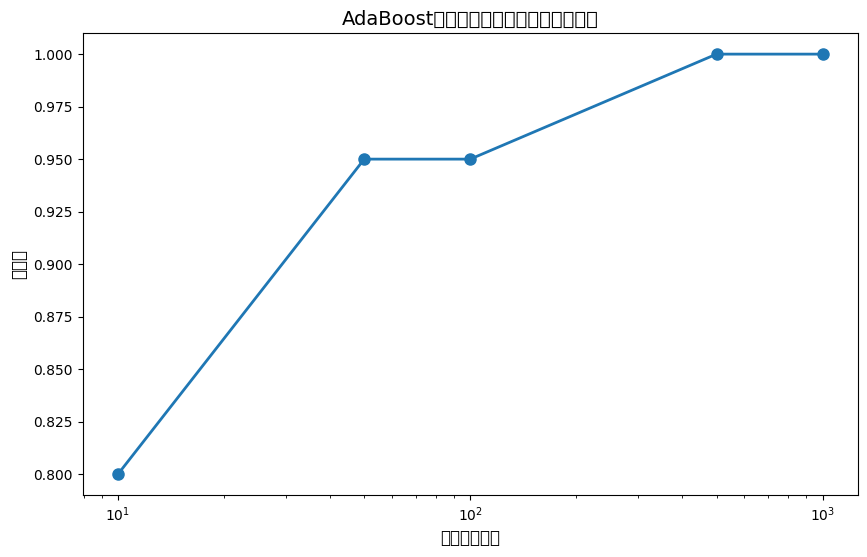

In [9]:
# 3.4 弱分类器数量对准确率的影响
n_estimators = [10, 50, 100, 500, 1000]
ada_accuracies = []

for n in n_estimators:
    model = AdaBoostClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    ada_accuracies.append(acc)
    print(f"弱分类器数量 {n}: 准确率 = {acc:.4f}")

# 绘制影响图
plt.figure(figsize=(10, 6))
plt.plot(n_estimators, ada_accuracies, 'o-', linewidth=2, markersize=8)
plt.xscale('log')
plt.xlabel('弱分类器数量', fontsize=12)
plt.ylabel('准确率', fontsize=12)
plt.title('AdaBoost中弱分类器数量对准确率的影响', fontsize=14, encode='utf-8')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('adaboost_accuracy_vs_estimators.png')
plt.close()

In [11]:
# === 5. XGBoost算法（选做）===
import xgboost as xgb
import time
from sklearn.metrics import classification_report

print("XGBoost版本:", xgb.__version__)

start_time = time.time()

# 创建DMatrix数据格式
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 设置参数
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# 训练模型
num_round = 100
bst = xgb.train(params, dtrain, num_round)

# 预测
y_pred_xgb = bst.predict(dtest)
y_pred_xgb = [1 if p > 0.5 else 0 for p in y_pred_xgb]

# 评估
xgb_score = accuracy_score(y_test, y_pred_xgb)
xgb_time = time.time() - start_time
print(f"XGBoost准确率: {xgb_score:.4f}, 耗时: {xgb_time:.2f}秒")
print("XGBoost分类报告:\n", classification_report(y_test, y_pred_xgb))

XGBoost版本: 2.1.4
XGBoost准确率: 0.9000, 耗时: 0.61秒
XGBoost分类报告:
               precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       1.00      0.80      0.89        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20



In [12]:
import lightgbm as lgb
print("LightGBM版本:", lgb.__version__)

start_time = time.time()

# 创建数据集
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 设置参数
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42
}

# 训练模型
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# 预测
y_pred_lgb = bst.predict(X_test)
y_pred_lgb = [1 if p > 0.5 else 0 for p in y_pred_lgb]

# 评估
lgb_score = accuracy_score(y_test, y_pred_lgb)
lgb_time = time.time() - start_time
print(f"LightGBM准确率: {lgb_score:.4f}, 耗时: {lgb_time:.2f}秒")
print("LightGBM分类报告:\n", classification_report(y_test, y_pred_lgb))

LightGBM版本: 4.6.0
LightGBM准确率: 0.9500, 耗时: 0.18秒
LightGBM分类报告:
               precision    recall  f1-score   support

         0.0       0.91      1.00      0.95        10
         1.0       1.00      0.90      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20

